# Example: Reading geospatial point time-series

This example illustrates the how to read geospatial point time-series data here called `GeoDataset`, using the HydroMT [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst) with the `vector` and `netcdf` or `zarr` drivers.

In [1]:
from pprint import pprint

import numpy as np

import hydromt

In [2]:
# Download artifacts for the Piave basin
data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])

## Xarray Driver

To read geospatial point time-series data and parse it into a [xarray Dataset or DataArray](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) we use the [open_mfdataset()](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) or the [open_zarr()](https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html#xarray.open_zarr) method. All `options` in the data catalog yaml file will be passed to to these methods. 

As an example we will use the [GTSM data](hhttps://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.8c59054f?tab=overview) dataset which is stored in Netcdf format. 

In [3]:
# inspect data source entry in data catalog yaml file
data_catalog.get_source("gtsmv3_eu_era5")

GeoDatasetSource(name='gtsmv3_eu_era5', uri='gtsmv3_eu_era5.nc', data_adapter=GeoDatasetAdapter(unit_add={}, unit_mult={}, rename={}), driver=GeoDatasetXarrayDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7718187f62b0>, options={}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7718187f62b0>, options={}), root='/home/sam/.hydromt/artifact_data/v1.0.0', version='3.0', provider=None, metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category='ocean', paper_doi='10.24381/cds.8c59054f', paper_ref='Copernicus Climate Change Service 2019', url='https://cds.climate.copernicus.eu/cds

We can load any geospatial point time-series data using [DataCatalog.get_geodataset()](../_generated/hydromt.data_catalog.DataCatalog.get_geodataset.rst). Note that if we don't provide any arguments it returns the full dataset with all data variables and for the full spatial domain.  The result is per default returned as DataArray as the dataset consists of a single variable. To return a dataset  use the `single_var_as_array=False` argument. Only the data coordinates and the time are actually read, the data variables are still lazy [Dask arrays](https://docs.dask.org/en/stable/array.html).

In [4]:
ds = data_catalog.get_geodataset("gtsmv3_eu_era5", single_var_as_array=False)
ds

object: GeoDatasetXarrayDriver does not use kwarg predicate with value intersects.


<xarray.Dataset> Size: 323kB
Dimensions:      (stations: 19, time: 2016)
Coordinates:
    lon          (stations) float64 152B dask.array<chunksize=(19,), meta=np.ndarray>
  * time         (time) datetime64[ns] 16kB 2010-02-01 ... 2010-02-14T23:50:00
    lat          (stations) float64 152B dask.array<chunksize=(19,), meta=np.ndarray>
    spatial_ref  int32 4B ...
  * stations     (stations) int32 76B 13670 2798 2799 13775 ... 2791 2790 2789
Data variables:
    waterlevel   (time, stations) float64 306kB dask.array<chunksize=(2016, 19), meta=np.ndarray>
Attributes:
    crs:        4326
    category:   ocean
    paper_doi:  10.24381/cds.8c59054f
    paper_ref:  Copernicus Climate Change Service 2019
    url:        https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/c...
    license:    https://cds.climate.copernicus.eu/cdsapp/#!/terms/licence-to-...

The data can be visualized with the [DataArray.plot()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html) xarray method. We show the evolution of the water level over time for a specific point location (station). 

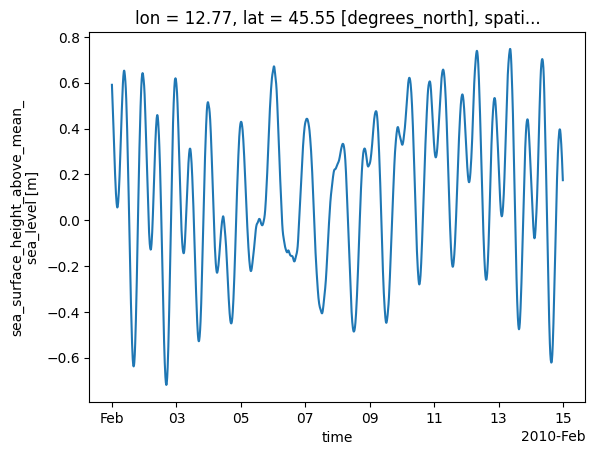

In [5]:
ds.sel(stations=2791)["waterlevel"].plot()

We can request a (spatial) subset data by providing additional `variables` and `bbox` / `geom` arguments. Note that these return less stations and less variables. In this example only spatial arguments are applied as only a single variable is available. The variables argument is especially useful if each variable of the dataset is saved in a separate file and the `{variable}` key is used in the path argument of the data source to limit which files are actually read. If a single variable is requested a DataArray instead of a Dataset is returned unless the `single_var_as_array` argument is set to False (True by default).

In [6]:
bbox = [12.50, 45.20, 12.80, 45.40]
ds_bbox = data_catalog.get_geodataset("gtsmv3_eu_era5", bbox=bbox)
ds_bbox

object: GeoDatasetXarrayDriver does not use kwarg predicate with value intersects.


<xarray.DataArray 'waterlevel' (time: 2016, stations: 2)> Size: 32kB
dask.array<getitem, shape=(2016, 2), dtype=float64, chunksize=(2016, 2), chunktype=numpy.ndarray>
Coordinates:
    lon          (stations) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * time         (time) datetime64[ns] 16kB 2010-02-01 ... 2010-02-14T23:50:00
    lat          (stations) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    spatial_ref  int32 4B ...
  * stations     (stations) int32 8B 13775 13723
Attributes:
    long_name:       sea_surface_height_above_mean_sea_level
    units:           m
    CDI_grid_type:   unstructured
    short_name:      waterlevel
    description:     Total water level resulting from the combination of baro...
    category:        ocean
    paper_doi:       10.24381/cds.8c59054f
    paper_ref:       Copernicus Climate Change Service 2019
    source_license:  https://cds.climate.copernicus.eu/cdsapp/#!/terms/licenc...
    source_url:      https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24...
    source_version:  GTSM v3.0

With a Geodataset, you can also directly access the associated point geometries using its [to_gdf()](../_generated/hydromt.gis.DataArray.vector.to_gdf.rst) method. Multi-dimensional data (e.g. the time series) can be reduced using a statistical method such as the max.

In [7]:
pprint(ds_bbox.vector.to_gdf(reducer=np.nanmax))

                           geometry  waterlevel
stations                                       
13775     POINT (12.75879 45.24902)    0.703679
13723     POINT (12.50244 45.25635)    0.721433


<GeoAxes: >

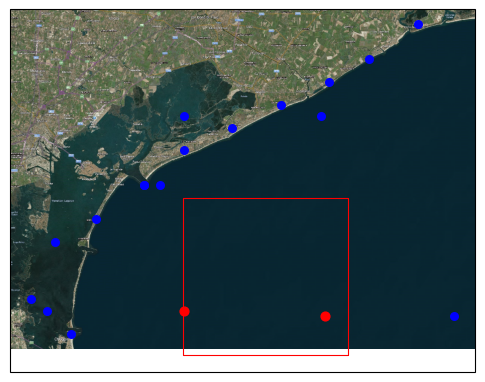

In [8]:
# Plot
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6, 10))
ax = plt.subplot(projection=proj)

bbox = gpd.GeoDataFrame(geometry=[box(12.50, 45.20, 12.80, 45.40)], crs=4326)

ax.add_image(cimgt.QuadtreeTiles(), 12)
# Plot the points
ds.vector.to_gdf().plot(ax=ax, markersize=30, c="blue", zorder=2)
ds_bbox.vector.to_gdf().plot(ax=ax, markersize=40, c="red", zorder=2)
# Plot the bounding box
bbox.boundary.plot(ax=ax, color="red", linewidth=0.8)

## Vector driver

To read vector data and parse it into a [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html#xarray.Dataset) object we use the [open_geodataset()](../_generated/hydromt.data_catalog.DataCatalog.get_geodataset.rst) method. Combined point locations (e.g. CSV or GeoJSON) data as well as text delimited time series (e.g. CSV) data are supported as file formats (see [DataCatalog documentation](../guides/advanced_user/data_types.rst#csv-point-time-series-data)). Both formats must contain an index and a crs has to be indicated in the .yml file. For demonstration we use dummy example data from the *examples/data* folder. 

First load the data catalog of the corresponding example data *geodataset_catalog.yml*:

In [9]:
geodata_catalog = hydromt.DataCatalog("data/geodataset_catalog.yml")
geodata_catalog.get_source("waterlevels_txt")

GeoDatasetSource(name='waterlevels_txt', uri='stations.csv', data_adapter=GeoDatasetAdapter(unit_add={}, unit_mult={}, rename={'stations_data': 'waterlevel'}), driver=GeoDatasetVectorDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7718187f62b0>, options={'data_path': 'stations_data.csv'}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7718187f62b0>, options={}), root='data', version=None, provider=None, metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category=None))

We see here that our locations are defined in a *data/stations.csv* file and a *data/stations_data.csv*. Let's check the content of these files before loading them with the `get_geodataset` method:

In [10]:
import pandas as pd

print("Stations locations:")
df_stations = pd.read_csv("data/stations.csv")
pprint(df_stations)

Stations locations:
   stations         x         y
0      1001  12.50244  45.25635
1      1002  12.75879  45.24902


In [11]:
print("Stations data:")
df_stations_data = pd.read_csv("data/stations_data.csv")
pprint(df_stations_data.head(3))

Stations data:
         time      1001      1002
0  2016-01-01  0.590860  0.591380
1  2016-01-02  0.565552  0.571342
2  2016-01-03  0.538679  0.549770


In [12]:
ds = geodata_catalog.get_geodataset("waterlevels_txt", single_var_as_array=False)
ds

object: GeoDatasetVectorDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category=None.


<xarray.Dataset> Size: 48kB
Dimensions:      (time: 2016, stations: 2)
Coordinates:
  * time         (time) datetime64[ns] 16kB 2016-01-01 2016-01-02 ... 2021-07-08
  * stations     (stations) int64 16B 1001 1002
    geometry     (stations) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    spatial_ref  int64 8B 0
Data variables:
    waterlevel   (stations, time) float64 32kB dask.array<chunksize=(2, 2016), meta=np.ndarray>
Attributes:
    crs:      4326